In [1]:
# import common APIs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn import cross_validation, naive_bayes, tree, svm, ensemble
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve
from xgboost import XGBClassifier

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data observation

In [2]:
# Data observation
filepath = '/Users/mac/Desktop/Kaggle_datasets/Med_Appointment/'
filename01 = 'KaggleV2-052016.csv'

df_full = pd.read_csv(os.path.join(filepath, filename01))
df_full.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
df_full.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [5]:
df_full.Handcap.value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [ ]:
##太久了...
df_dum = pd.get_dummies(df_full[['Gender', 'ScheduledDay','AppointmentDay', 'Age', 
                                'Neighbourhood', 'Scholarship', 'Hipertension','Diabetes', 
                                'Alcoholism', 'Handcap', 'SMS_received', 'No-show']])

# Corr heatmap：直接看一排相關係數高低
k = 20 #number of variables for heatmap
corrmat = df_dum.corr()
cols = corrmat.nlargest(k, 'No-show')['No-show'].index
cm = np.corrcoef(df_dum[cols].values.T)

plt.figure(figsize=(15,15)) #可以調整大小
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels = cols.values, xticklabels = cols.values, cmap='rainbow')
hm.xaxis.set_ticks_position('top')
plt.show()

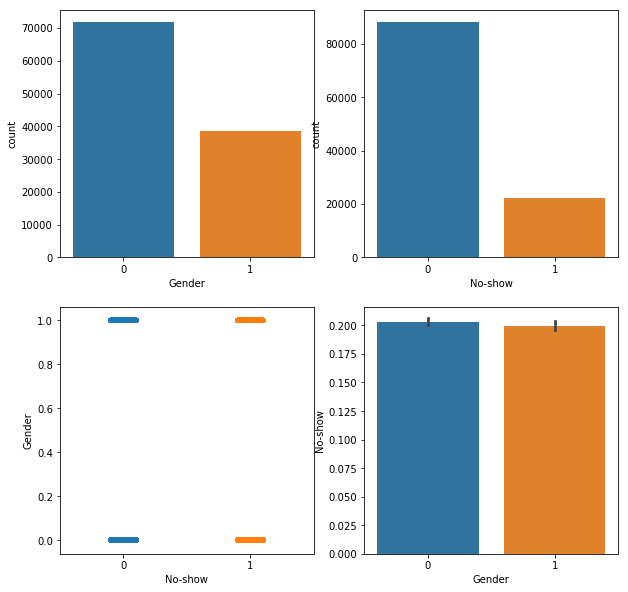

In [38]:
fig, ([axis1,axis2],[axis3,axis4]) = plt.subplots(2,2,figsize=(10,10))
sns.countplot(x='Gender', data=df_num, ax=axis1)
sns.countplot(x='No-show', data=df_num, ax=axis2)
sns.stripplot(x='No-show', y='Gender', data=df_num, ax=axis3, jitter=True)
sns.barplot(x='Gender', y='No-show', data=df_num, ax=axis4)
plt.show()

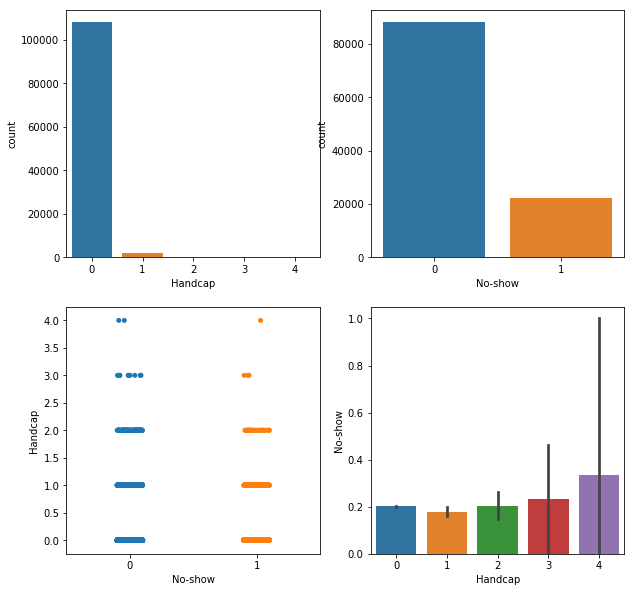

In [39]:
fig, ([axis1,axis2],[axis3,axis4]) = plt.subplots(2,2,figsize=(10,10))
sns.countplot(x='Handcap', data=df_num, ax=axis1)
sns.countplot(x='No-show', data=df_num, ax=axis2)
sns.stripplot(x='No-show', y='Handcap', data=df_num, ax=axis3, jitter=True)
sns.barplot(x='Handcap', y='No-show', data=df_num, ax=axis4)
plt.show()

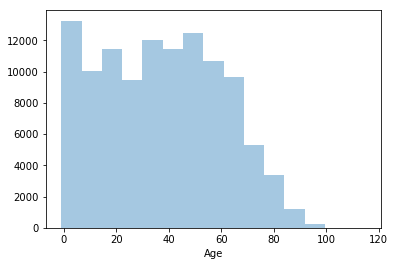

In [6]:
sns.distplot(df_full['Age'], kde=False, bins=15)
plt.show()

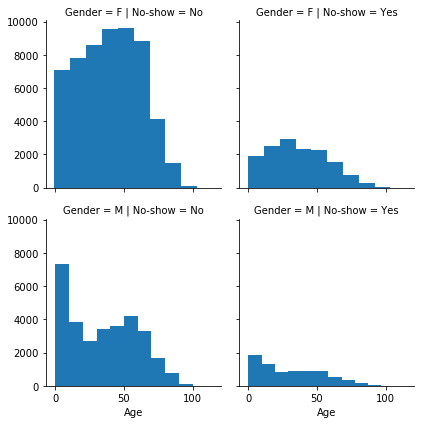

In [11]:
g = sns.FacetGrid(df_full, col='No-show', row='Gender')
g.map(plt.hist, 'Age') #使用年齡的分佈做圖兩個變項
plt.show()

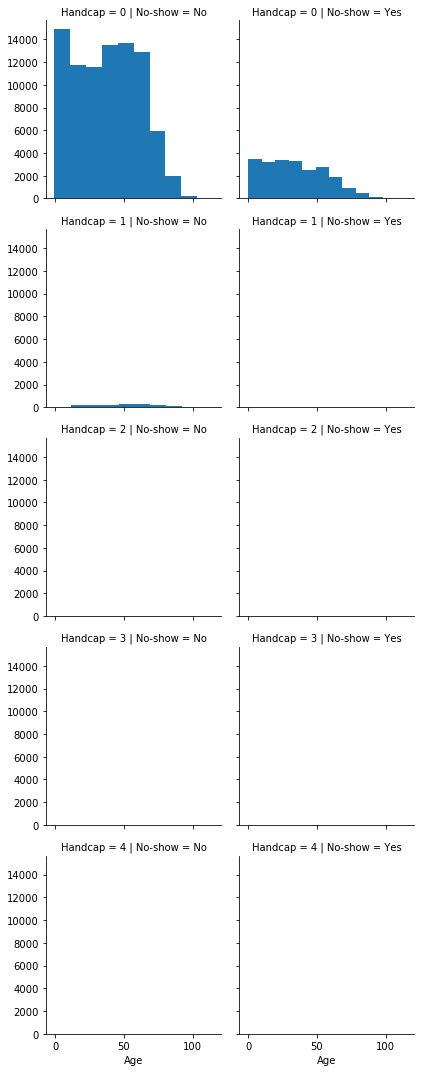

In [12]:
g = sns.FacetGrid(df_full, col='No-show', row='Handcap')
g.map(plt.hist, 'Age') #使用年齡的分佈做圖兩個變項
plt.show() #由此可見Handcap是重要因子

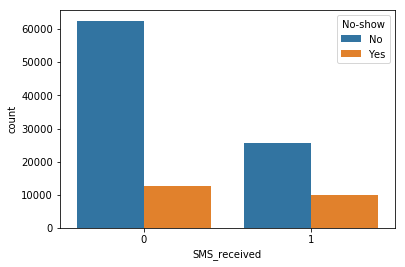

In [13]:
# graph distribution of sms reminders
sns.countplot(x='SMS_received', hue='No-show', data=df_full)
plt.show()

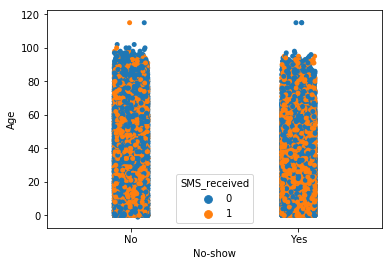

In [16]:
sns.stripplot(x='No-show', y='Age', data=df_full, 
              hue='SMS_received', jitter=True)
plt.show()

# Data preprocessing

In [33]:
cols = ['Gender','Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
        'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']

df_num = df_full[cols].apply(LabelEncoder().fit_transform)
df_num.head() #F:0/M:1, No:0/Yes:1

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,0,63,39,0,1,0,0,0,0,0
1,1,57,39,0,0,0,0,0,0,0
2,0,63,45,0,0,0,0,0,0,0
3,0,9,54,0,0,0,0,0,0,0
4,0,57,39,0,1,1,0,0,0,0


In [34]:
#可是效果並沒有變好
scaler = MinMaxScaler()
scaler.fit(df_num.Age.values.reshape(-1, 1))
df_num['Age'] = scaler.transform(df_num.Age.values.reshape(-1, 1))

//anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [35]:
df_num = pd.get_dummies(df_num, columns=['Neighbourhood'])

In [41]:
df_num.head()

,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Neighbourhood_0,...,Neighbourhood_71,Neighbourhood_72,Neighbourhood_73,Neighbourhood_74,Neighbourhood_75,Neighbourhood_76,Neighbourhood_77,Neighbourhood_78,Neighbourhood_79,Neighbourhood_80
0,0,0.611650,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0.553398,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.611650,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.087379,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.553398,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# Data preprocessing
from sklearn.utils import shuffle

shuffle_df = shuffle(df_num, random_state=42)

df_label = shuffle_df['No-show']
df_feature = shuffle_df.drop('No-show', axis=1)

cut_point = round(len(df_num)*0.6)
train_feature = np.array(df_feature.values[:cut_point,:])
train_label = np.array(df_label.values[:cut_point])
test_feature = np.array(df_feature.values[cut_point:,:])
test_label = np.array(df_label.values[cut_point:])

# Scikit-Learn: 不論是MinMaxScaler或者是get dummies都沒有讓結果變好～

In [25]:
### naive_bayes.BernoulliNB()
from sklearn import cross_validation, naive_bayes
X_train,X_test,y_train,y_test = cross_validation.train_test_split(train_feature,train_label, 
                                              test_size=0.25, random_state=0,stratify=train_label)
clf=naive_bayes.BernoulliNB()
clf.fit(X_train,y_train)
print("Traing Score:%f"%clf.score(train_feature,train_label))
print("Testing Score:%f"%clf.score(test_feature,test_label))

y_predict = clf.predict(X_test)
print('\n'+classification_report(y_test,y_predict))

y_predict2 = clf.predict(test_feature)
print('\n'+classification_report(test_label,y_predict2))

Traing Score:0.798178
Testing Score:0.797810

             precision    recall  f1-score   support

          0       0.80      1.00      0.89     13233
          1       1.00      0.00      0.00      3346

avg / total       0.84      0.80      0.71     16579


             precision    recall  f1-score   support

          0       0.80      1.00      0.89     35276
          1       0.00      0.00      0.00      8935

avg / total       0.64      0.80      0.71     44211



In [26]:
### naive_bayes.GaussianNB()
from sklearn import cross_validation, naive_bayes
X_train,X_test,y_train,y_test = cross_validation.train_test_split(train_feature,train_label, 
                                              test_size=0.25, random_state=0,stratify=train_label)
clf=naive_bayes.GaussianNB()
clf.fit(X_train,y_train)
print("Traing Score:%f"%clf.score(train_feature,train_label))
print("Testing Score:%f"%clf.score(test_feature,test_label))

y_predict = clf.predict(X_test)
print('\n'+classification_report(y_test,y_predict))

y_predict2 = clf.predict(test_feature)
print('\n'+classification_report(test_label,y_predict2))

Traing Score:0.244994
Testing Score:0.244600

             precision    recall  f1-score   support

          0       0.81      0.07      0.13     13233
          1       0.20      0.94      0.33      3346

avg / total       0.69      0.24      0.17     16579


             precision    recall  f1-score   support

          0       0.82      0.07      0.13     35276
          1       0.20      0.94      0.34      8935

avg / total       0.70      0.24      0.17     44211



In [27]:
### tree.DecisionTreeClassifier()
from sklearn import cross_validation,tree
X_train,X_test,y_train,y_test = cross_validation.train_test_split(train_feature,train_label, 
                                              test_size=0.25, random_state=0,stratify=train_label)
clf=tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)
print("Traing Score:%f"%clf.score(train_feature,train_label))
print("Testing Score:%f"%clf.score(test_feature,test_label))

y_predict = clf.predict(X_test)
print('\n'+classification_report(y_test,y_predict))

y_predict2 = clf.predict(test_feature)
print('\n'+classification_report(test_label,y_predict2))

Traing Score:0.841939
Testing Score:0.747371

             precision    recall  f1-score   support

          0       0.81      0.90      0.85     13233
          1       0.27      0.14      0.19      3346

avg / total       0.70      0.75      0.72     16579


             precision    recall  f1-score   support

          0       0.81      0.90      0.85     35276
          1       0.28      0.15      0.20      8935

avg / total       0.70      0.75      0.72     44211



In [28]:
### svm.LinearSVC()
from sklearn import cross_validation,svm
X_train,X_test,y_train,y_test = cross_validation.train_test_split(train_feature,train_label, 
                                              test_size=0.25, random_state=0,stratify=train_label)
clf=svm.LinearSVC()
clf.fit(X_train,y_train)
print("Traing Score:%f"%clf.score(train_feature,train_label))
print("Testing Score:%f"%clf.score(test_feature,test_label))

y_predict = clf.predict(X_test)
print('\n'+classification_report(y_test,y_predict))

y_predict2 = clf.predict(test_feature)
print('\n'+classification_report(test_label,y_predict2))

Traing Score:0.798178
Testing Score:0.797901

             precision    recall  f1-score   support

          0       0.80      1.00      0.89     13233
          1       0.00      0.00      0.00      3346

avg / total       0.64      0.80      0.71     16579


             precision    recall  f1-score   support

          0       0.80      1.00      0.89     35276
          1       0.00      0.00      0.00      8935

avg / total       0.64      0.80      0.71     44211



//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
### ensemble.AdaBoostClassifier()
from sklearn import cross_validation,ensemble
X_train,X_test,y_train,y_test = cross_validation.train_test_split(train_feature,train_label, 
                                              test_size=0.25, random_state=0,stratify=train_label) #分層取樣
clf=ensemble.AdaBoostClassifier()
clf.fit(X_train,y_train)
print("Traing Score:%f"%clf.score(train_feature,train_label))
print("Testing Score:%f"%clf.score(test_feature,test_label))

y_predict = clf.predict(X_test)
print('\n'+classification_report(y_test,y_predict))

y_predict2 = clf.predict(test_feature)
print('\n'+classification_report(test_label,y_predict2))

Traing Score:0.798209
Testing Score:0.797765

             precision    recall  f1-score   support

          0       0.80      1.00      0.89     13233
          1       0.50      0.00      0.00      3346

avg / total       0.74      0.80      0.71     16579


             precision    recall  f1-score   support

          0       0.80      1.00      0.89     35276
          1       0.12      0.00      0.00      8935

avg / total       0.66      0.80      0.71     44211



In [30]:
### ensemble.RandomForestClassifier()
from sklearn import cross_validation,ensemble
X_train,X_test,y_train,y_test = cross_validation.train_test_split(train_feature,train_label, 
                                              test_size=0.25, random_state=0,stratify=train_label) #分層取樣
clf=ensemble.RandomForestClassifier()
clf.fit(X_train,y_train)
print("Traing Score:%f"%clf.score(train_feature,train_label))
print("Testing Score:%f"%clf.score(test_feature,test_label))

y_predict = clf.predict(X_test)
print('\n'+classification_report(y_test,y_predict))

y_predict2 = clf.predict(test_feature)
print('\n'+classification_report(test_label,y_predict2))

Traing Score:0.833539
Testing Score:0.745855

             precision    recall  f1-score   support

          0       0.81      0.89      0.85     13233
          1       0.27      0.16      0.20      3346

avg / total       0.70      0.74      0.72     16579


             precision    recall  f1-score   support

          0       0.81      0.89      0.85     35276
          1       0.29      0.18      0.22      8935

avg / total       0.70      0.75      0.72     44211



In [31]:
# XGBClassifier()
from xgboost import XGBClassifier
X_train,X_test,y_train,y_test = cross_validation.train_test_split(train_feature,train_label, 
                                              test_size=0.25, random_state=0,stratify=train_label) #分層取樣
clf=XGBClassifier()
clf.fit(X_train,y_train)
print("Traing Score:%f"%clf.score(train_feature,train_label))
print("Testing Score:%f"%clf.score(test_feature,test_label))

y_predict = clf.predict(X_test)
print('\n'+classification_report(y_test,y_predict))

y_predict2 = clf.predict(test_feature)
print('\n'+classification_report(test_label,y_predict2))

Traing Score:0.798209
Testing Score:0.797856

             precision    recall  f1-score   support

          0       0.80      1.00      0.89     13233
          1       0.00      0.00      0.00      3346

avg / total       0.64      0.80      0.71     16579


             precision    recall  f1-score   support

          0       0.80      1.00      0.89     35276
          1       0.00      0.00      0.00      8935

avg / total       0.64      0.80      0.71     44211



//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Keras: MLP，效果穩定，跟最佳的Skl差不多強

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               45000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 201       
Total params: 145,401
Trainable params: 145,401
Non-trainable params: 0
_________________________________________________________________
None
Train on 13263 samples, validate on 53053 samples
Epoch 1/50
13263/13263 [==============================] - 2s - loss: 0.6663 - acc

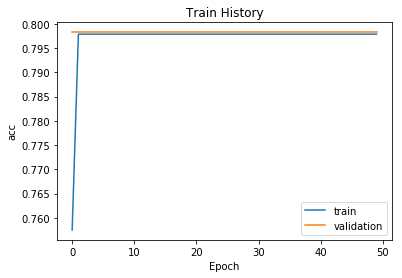

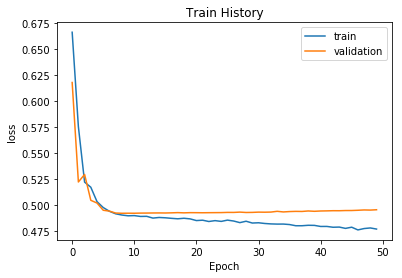

43712/44211 [============================>.] - ETA: 0s

accuracy= 0.797900974866


In [43]:
# Keras MLP models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

model = Sequential() 
model.add(Dense(units=500, 
                input_dim=89, 
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=200,  
                kernel_initializer='uniform', 
                activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=1, #輸出一個數字 
                kernel_initializer='uniform',
                activation='sigmoid'))

print(model.summary()) #可以清楚看到model還有參數數量

model.compile(loss='binary_crossentropy',   #二元用binary
              optimizer='adam', metrics=['accuracy'])

train_history = model.fit(x=train_feature, y=train_label,  #上面多分割一步在keras是內建的
                          validation_split=0.8, epochs=50, 
                          batch_size=2000, verbose=2) #verbose=2表示顯示訓練過程

show_train_history(train_history,'acc','val_acc')
show_train_history(train_history,'loss','val_loss')

scores = model.evaluate(test_feature, test_label)
print('\n')
print('accuracy=',scores[1])